In [16]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import MultiPoint
import aesara.tensor as at

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

data = gpd.read_file(DATA_DIR / "spatial_income_1880.gpkg")
data["is_old"] = data.is_old.astype(int)
data = (data.drop(index=data[data.population < 5].index).dropna().reset_index())

xy = pd.DataFrame({"x": data.geometry.x, "y": data.geometry.y, "group": data.group})
grouped = xy.groupby("group").mean()

d = distance_matrix(xy, xy)
d_clusters = distance_matrix(grouped, grouped)
P_norm = StandardScaler().fit_transform(data.lutheran_ln.values.reshape(-1, 1)).flatten()
O_norm = StandardScaler().fit_transform(data.orthodox_proportion_ln.values.reshape(-1, 1)).flatten()

N = data.shape[0]
SEED = 42
N_CLUSTERS = len(data.group.unique())
assert N_CLUSTERS, N_CLUSTERS == d.shape

In [12]:
cluster_colors = plt.get_cmap("tab20")
data.explore(
    column="group",
    categorical=True,
    cmap=cluster_colors,
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [13]:
data.explore(
    column="lutheran",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [14]:
data.explore(
    column="orthodox_proportion",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

# Model 1

$$ O \sim Beta(\mu, \sigma) $$
$$ \sigma \sim HalfNormal(0.01) $$
$$ \mu = \frac{1}{1 - exp(\beta_{k,0} + \beta_{k,1} W)} $$
$$ \beta \sim MvNormal \left( \theta, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ \theta \sim Normal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 \\ 0.1 \end{bmatrix} \right) $$

In [15]:
with pm.Model() as model_1:
    idx = data.group
    W = pm.MutableData("W", data.total_income_ln)

    θ = pm.Normal("θ", [0, 0], [0.1, 0.1], shape=2)

    β = pm.MvNormal(
        "β", mu=θ, cov=np.diagflat(np.array([ 0.1, 0.1])), shape=(N_CLUSTERS, 2)
    )
    μ = at.math.sigmoid(β[idx, 0] + β[idx, 1] * W)
    σ = pm.HalfNormal("σ", 0.01)

    O = pm.Beta("O", mu=μ, sigma=σ, observed=data.orthodox_proportion)

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True, target_accept=0.95)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

Sampling: [O, β, θ, σ]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1049 seconds.
Sampling: [O]


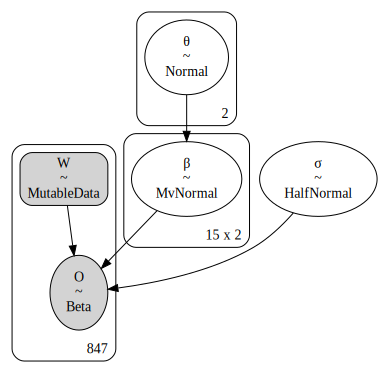

In [16]:
graph_1 = pm.model_to_graphviz(model_1)
graph_1

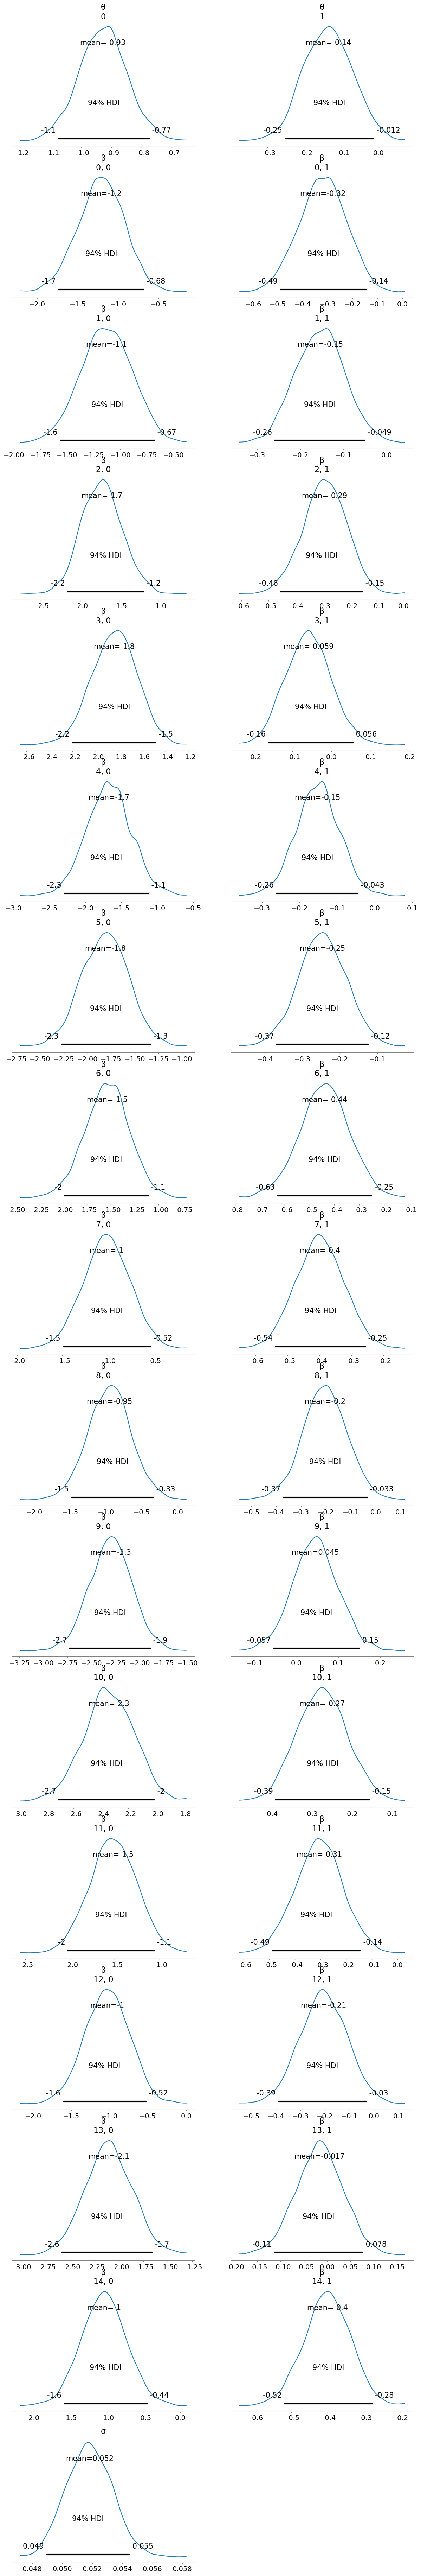

In [20]:
# az.plot_posterior(posterior_1, grid=(N_CLUSTERS + 2, 2))
# plt.show()


In [ ]:
az.plot_trace(posterior_1)
plt.show()

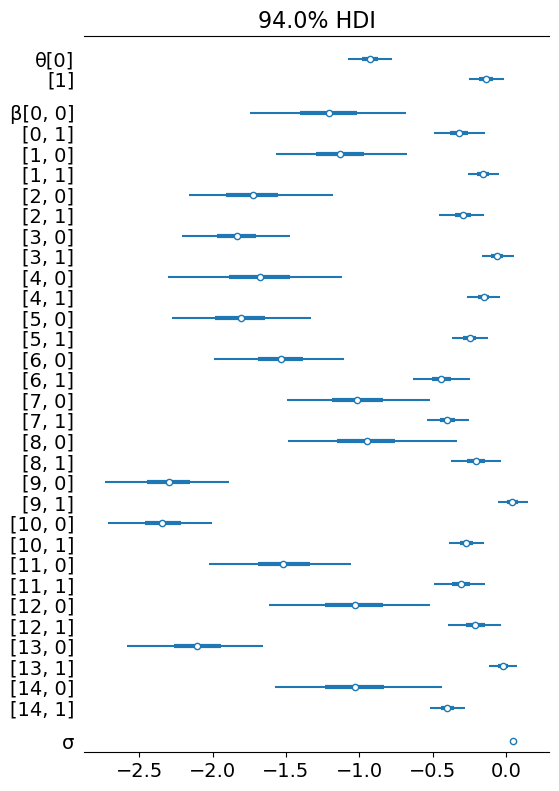

In [18]:
az.plot_forest(posterior_1, combined=True, hdi_prob=0.94)
plt.show()

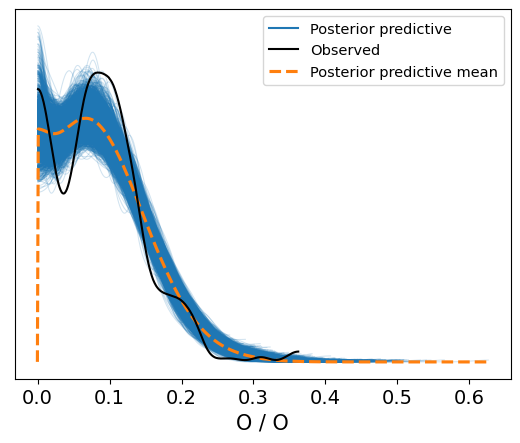

In [19]:
az.plot_ppc(posterior_prediction_1)
plt.show()

# Model 2

In [17]:
with pm.Model() as model_2:
    idx = data.group.loc[::5]
    W = pm.MutableData("W", data.total_income_ln.loc[::5])
    N = 170
    d = d[::5, ::5]

    θ = pm.Normal("θ", [0, 0], [0.1, 0.1], shape=2)
    # chol, ρ, σ_β = pm.LKJCholeskyCov("chol_cov", n=2, eta=5, sd_dist=pm.HalfNormal.dist(0.5), compute_corr=True)
    # β = pm.MvNormal(
        # "β", mu=θ, chol=chol, shape=(N_CLUSTERS, 2)
    # )
    β = pm.MvNormal(
        "β", mu=θ, cov=np.diagflat(np.array([ 0.1, 0.1])), shape=(N_CLUSTERS, 2)
    )

    η2 = pm.HalfStudentT('η²', 1, 10)
    ρ2 = pm.HalfStudentT('ρ²', 1, 10)
    K = η2 * (at.exp(-ρ2 * np.power(d, 2) ** 2) + np.diag([0.01] * N))
    
    ε = pm.MvNormal("ε", mu=np.zeros(N), cov=K, shape=N)
    μ = β[idx, 0] + β[idx, 1] * W + ε
    σ = pm.HalfNormal("σ_O", 0.01)
    O = pm.Normal("O", mu=μ, sigma=σ, observed=O_norm[::5])

    prior_2 = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    posterior_2 = pm.sample(
        draws=1000,
        tune=1000,
        init="adapt_diag",
        return_inferencedata=True,
        target_accept=0.95,
        random_seed=SEED,
    )
    posterior_prediction_2 = pm.sample_posterior_predictive(
        posterior_2, 
        random_seed=SEED,
    )

Sampling: [O, β, ε, η², θ, ρ², σ_O]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, β, η², ρ², ε, σ_O]
